# Deep Convolutional Generative Adversarial Network

In [0]:
import keras 
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

## Generator network

In [21]:
generator_input = keras.Input(shape=(latent_dim,))  # (32, )

x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

# Discriminator network

In [22]:
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_27 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

In [0]:
discriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, 
                      loss='binary_crossentropy')

## Adverserial Network

In [0]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## Training the GAN

In [0]:
import os 
from keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

In [0]:
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/'

In [27]:
start = 0
for step in range(iterations):
    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    # decode them into face image
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start: stop]
    
    # Combine real and fake images
    combined_images = np.concatenate([generated_images, real_images])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    # Add random noise to labels, which is very importent
    labels += 0.05 * np.random.random(labels.shape)
    
    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # sample random points in latent space
    random_latent_vectors = np.random.random(size=(batch_size, latent_dim))
    # assamples labels saying these all are real images, which is a lie
    misleading_targets = np.zeros((batch_size, 1))
    
    # Traing the generator via gan model, where the discrimnator is frozen
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
    if step % 100 == 0:
        print('step: ', step)
        gan.save_weights('gan.h5')
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)

        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,'generated_frog' + str(step) + '.png'))
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

ResourceExhaustedError: ignored

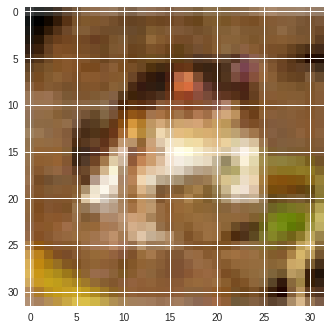

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/real_frog2100.png')
imgplot = plt.imshow(img)
plt.show()

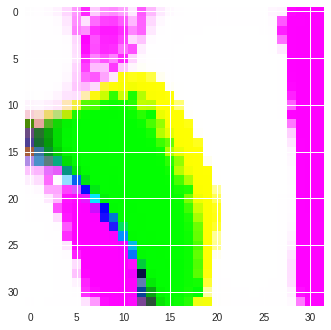

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/generated_frog0.png')
imgplot = plt.imshow(img)
plt.show()

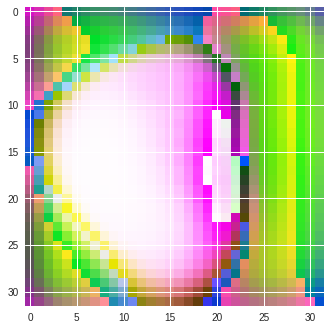

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/generated_frog7900.png')
imgplot = plt.imshow(img)
plt.show()